<a href="https://colab.research.google.com/github/mahdi-rostami/Timeseries-Forecasting/blob/main/Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sb
import numpy as np
import gc
from operator import itemgetter
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics


warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#download data
import os 
if not os.path.isfile('LOB_NQU22-CME.csv'):
    !wget https://raw.githubusercontent.com/0xtweeter/Timeseries-Forecasting/main/data/LOB_NQU22-CME.rar
    !pip install unrar
    !unrar x "/content/LOB_NQU22-CME.rar"
    print('data downloaded and exteracted')
else :
    print('csv file already existed.')

--2022-11-17 15:15:01--  https://raw.githubusercontent.com/0xtweeter/Timeseries-Forecasting/main/data/LOB_NQU22-CME.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38220604 (36M) [application/octet-stream]
Saving to: ‘LOB_NQU22-CME.rar’

LOB_NQU22-CME.rar   100%[===================>]  36.45M   169MB/s    in 0.2s    

2022-11-17 15:15:02 (169 MB/s) - ‘LOB_NQU22-CME.rar’ saved [38220604/38220604]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/LOB_NQU22-CME.rar

Extracting  LOB_NQU22-CME.csv                                             10% 21% 32% 43% 54% 65% 76% 87% 98% 99%

In [ ]:
#plt style
# colors = cycler('color',
#                 ['#669FEE', '#66EE91', '#9988DD',
#                  '#EECC55', '#88BB44', '#FFBBBB'])
# plt.rc('figure', facecolor='#313233')
# plt.rc('axes', facecolor="#313233", edgecolor='none',
#        axisbelow=True, grid=True, prop_cycle=colors,
#        labelcolor='gray')
# plt.rc('grid', color='474A4A', linestyle='solid')
# plt.rc('xtick', color='gray')
# plt.rc('ytick', direction='out', color='gray')
# plt.rc('legend', facecolor="#313233", edgecolor="#313233")
# plt.rc("text", color="#C9C9C9")
plt.style.use('ggplot')

# EDA

In [ ]:
#reading dataset
pd.set_option('display.max_columns',None)  #to show all columns
colnames=[
    'time', 'open', 'high', 'low', 'close', 'volume',
     'numtrades', 'bidvolume', 'askvolume', 'lob_bid', 'lob_ask'
     ] #columns name
Data = pd.read_csv("/content/LOB_NQU22-CME.csv", names=colnames, header=None, index_col='time' )

In [ ]:
df = Data.copy()

In [ ]:
df.shape

(72907, 10)

In [ ]:
df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,lob_bid,lob_ask
time,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14019.500000|1|14019.750000|2|14020.000000|1|1...
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14020.750000|1|14021.000000|1|14021.250000|1|1...
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14022.500000|3|14022.750000|1|14023.000000|1|1...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 2022-03-18  00:00:00 to 2022-06-29  16:15:00
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       72907 non-null  float64
 1   high       72907 non-null  float64
 2   low        72907 non-null  float64
 3   close      72907 non-null  float64
 4   volume     72907 non-null  float64
 5   numtrades  72907 non-null  float64
 6   bidvolume  72907 non-null  float64
 7   askvolume  72907 non-null  float64
 8   lob_bid    72907 non-null  object 
 9   lob_ask    72907 non-null  object 
dtypes: float64(8), object(2)
memory usage: 6.1+ MB


In [ ]:
df.describe()

,open,high,low,close,volume,numtrades,bidvolume,askvolume
count,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000
mean,13339.652328,13343.960775,13335.343534,13339.642065,453.720521,413.374491,227.202546,226.517975
std,1264.345092,1263.763152,1264.884332,1264.338144,702.840828,633.438076,354.099034,354.567693
min,11071.000000,11076.750000,11068.500000,11071.250000,1.000000,1.000000,0.000000,0.000000
25%,12123.000000,12127.250000,12118.000000,12122.875000,60.000000,55.000000,29.000000,29.000000
50%,13458.250000,13464.250000,13453.500000,13458.500000,140.000000,128.000000,70.000000,70.000000
75%,14458.250000,14462.500000,14453.750000,14458.250000,600.000000,549.000000,299.000000,298.000000
max,15310.750000,15311.500000,15307.000000,15310.750000,14469.000000,11819.000000,7066.000000,7403.000000


## null items


In [ ]:
df.isnull().sum()

open         0
high         0
low          0
close        0
volume       0
numtrades    0
bidvolume    0
askvolume    0
lob_bid      0
lob_ask      0
dtype: int64

## Outliers

In [ ]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df.kurt(numeric_only=True)[:]
kurt

open         -1.327697
high         -1.327039
low          -1.328361
close        -1.327696
volume       24.174307
numtrades    18.861598
bidvolume    23.645504
askvolume    25.204776
dtype: float64

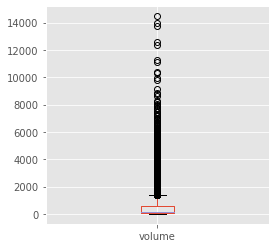

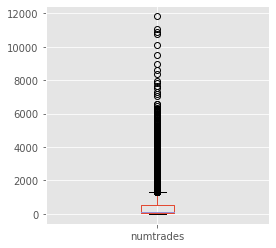

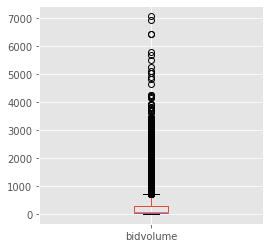

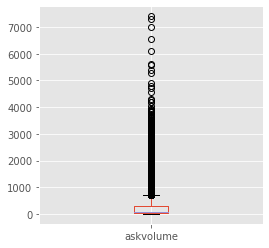

In [ ]:
outliers = ["volume", "numtrades", "bidvolume", "askvolume"]
for col in outliers:
    plt.figure(figsize=(4, 4))
    df.boxplot(column=[col])

In [ ]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [ ]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df[col])[0])}')

volume: 6380
numtrades: 6335
bidvolume: 6380
askvolume: 6403


In [ ]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df[col])[0])}')

volume: 1487
numtrades: 1530
bidvolume: 1495
askvolume: 1493


In [ ]:
for i in outliers:
    mean_y = np.mean(df[i])
    stdev_y = np.std(df[i])
    lower_bound = mean_y - (3 * stdev_y)
    upper_bound = mean_y + (3 * stdev_y)
    df = df[df[i]<upper_bound]
    df = df[df[i]>lower_bound]

In [ ]:
df.shape

(67121, 10)

## visualizing stock prices history

Text(0.5, 1.0, 'the total volume of stock being traded for E-mini Nasdaq-100')

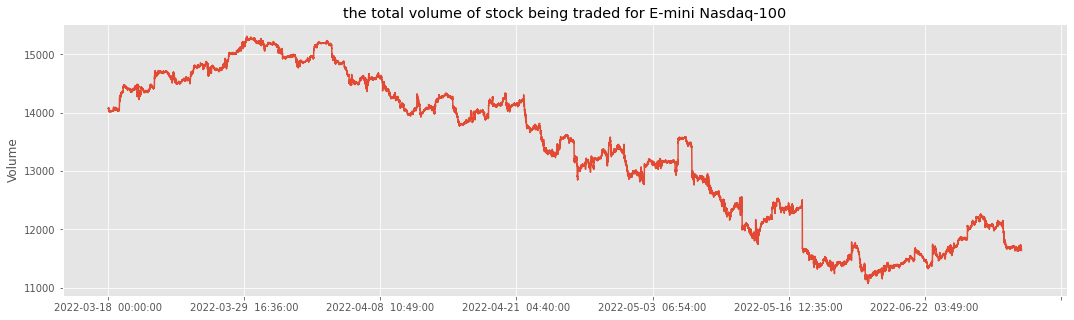

In [ ]:
plt.figure(figsize=(18,5))
df['close'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"the total volume of stock being traded for E-mini Nasdaq-100")

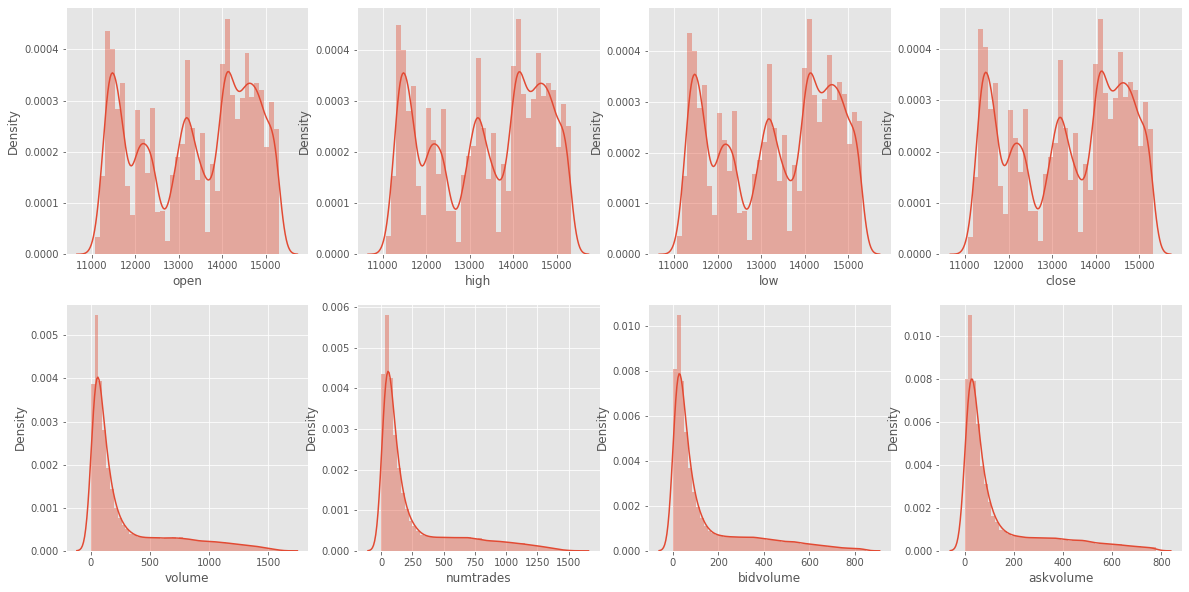

In [ ]:
features = ["open", "high",	"low", "close",	"volume",	"numtrades",	"bidvolume",	"askvolume"]
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,4,i+1)
  sb.distplot(df[col])
plt.show()

### The total volume of stock

Text(0.5, 1.0, 'the total volume of stock being traded each day for E-mini Nasdaq-100')

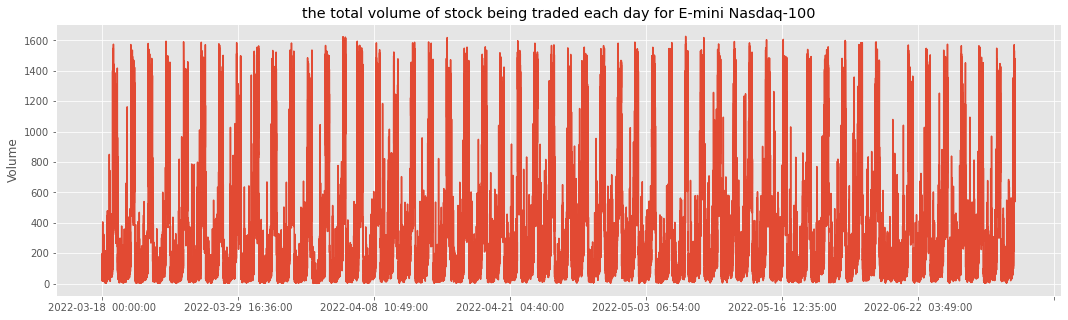

In [ ]:
plt.figure(figsize=(18,5))
df['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"the total volume of stock being traded each day for E-mini Nasdaq-100")

### Moving averages

In [ ]:
#dataframe daily
df_daily = df.copy()
df_daily.index = pd.to_datetime(df_daily.index)
df_daily = df_daily.resample('D').mean()
df_daily.dropna(axis = 0, inplace=True)
df_daily.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume
time,,,,,,,,
2022-03-18,14141.586726,14144.865140,14138.221374,14141.714801,304.256997,275.206107,151.964377,152.292621
2022-03-20,14453.708333,14456.345833,14451.579167,14453.681250,72.683333,65.491667,35.941667,36.741667
2022-03-21,14396.346698,14399.521030,14392.863404,14396.116352,282.197327,259.839623,142.043239,140.154088


In [ ]:
df_daily['ma for 5 days'] = df_daily['close'].rolling(5).mean()

<Figure size 1296x360 with 0 Axes>

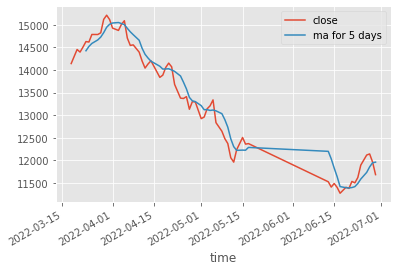

In [ ]:
plt.figure(figsize=(18,5))

df_daily[['close', 'ma for 5 days']].plot()

In [ ]:
del df_daily
gc.collect()

41509

# DATA LABELING

## close price labeling

In [ ]:
alpha_up = 0.5
alpha_down = -0.5
def filter(x):
    if x > alpha_up:
      x = +1
      return x
    elif x < alpha_down:
      x=-1
      return x
    else:
        return 0

In [ ]:
df['close_change'] = df['close'].diff()
df['close_lable'] = df["close_change"].apply(filter)
df.fillna(0, inplace=True)

In [ ]:
df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,lob_bid,lob_ask,close_change,close_lable
time,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14019.500000|1|14019.750000|2|14020.000000|1|1...,0.00,0
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14020.750000|1|14021.000000|1|14021.250000|1|1...,0.25,0
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14022.500000|3|14022.750000|1|14023.000000|1|1...,0.00,0


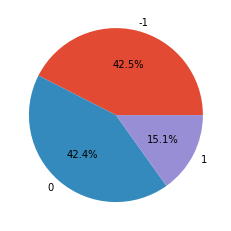

In [ ]:
plt.pie(df['close_lable'].value_counts().values,
        labels=[-1, 0, 1], autopct='%1.1f%%')
plt.show()

## ask-bid orders labeling

### ask column

In [ ]:
df['lob_ask'] = df["lob_ask"].str.split('|')

In [ ]:
for row in df.index:
  close = df.loc[row, "close"]
  lenght = len(df.loc[row, "lob_ask"])
  for index in range(lenght):
    number = float( df.loc[row, "lob_ask"][index])
    if number > close:
      df.loc[row, "lob_ask"] = str(df.loc[row, "lob_ask"][index:index+20])
      break

In [ ]:
df["lob_ask"] = df["lob_ask"].str.replace('[',"")
df["lob_ask"] = df["lob_ask"].str.replace(']',"")

df_ask = df["lob_ask"].str.split(',', expand=True)
df.drop(columns=["lob_ask"], inplace=True)

In [ ]:
for i in range(20):
  df_ask[i] = df_ask[i].str.replace("'","")
  df_ask[i] = df_ask[i].astype(float)

In [ ]:
ask_cols = [f'ask{i}' for i in range(20, 40)]
df_ask.columns = ask_cols

In [ ]:
df_ask.head(3)

,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39
time,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:01:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:02:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0


### bid cloumn

In [ ]:
df['lob_bid'] = df["lob_bid"].str.split('|')

In [ ]:
keys = [i for i in range(20)]
values = [itemgetter(-i) for i in range(2, 22)] 
 
myDict = { k:v for (k,v) in zip(keys, values)} 
df_bid = df['lob_bid'].transform(myDict)
df.drop(columns=["lob_bid"], inplace=True)

In [ ]:
for i in range(20):
  df_bid[i] = df_bid[i].astype(float)

In [ ]:
bid_cols = [f'bid{i}' for i in range(19,-1,-1)]
df_bid.columns = bid_cols

In [ ]:
df_bid = df_bid[[f'bid{i}' for i in range(20)]]

In [ ]:
df_bid.head(3)

,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19
time,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14024.25,2.0,14024.50,1.0,14024.75,1.0,14025.00,1.0,14025.25,2.0,14025.50,1.0,14025.75,1.0,14026.00,1.0,14026.25,2.0,14026.50,1.0
2022-03-18 00:01:00,14022.25,2.0,14022.50,2.0,14022.75,1.0,14023.00,1.0,14023.25,3.0,14023.50,2.0,14023.75,1.0,14024.00,1.0,14024.25,1.0,14024.50,2.0
2022-03-18 00:02:00,14023.00,2.0,14023.25,1.0,14023.50,1.0,14023.75,2.0,14024.00,1.0,14024.25,1.0,14024.50,1.0,14024.75,1.0,14025.00,2.0,14025.25,1.0


### bid & ask

In [ ]:
df_bidask =  pd.concat([df_bid, df_ask], axis=1)
df_bidask.head(3)

,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14024.25,2.0,14024.50,1.0,14024.75,1.0,14025.00,1.0,14025.25,2.0,14025.50,1.0,14025.75,1.0,14026.00,1.0,14026.25,2.0,14026.50,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:01:00,14022.25,2.0,14022.50,2.0,14022.75,1.0,14023.00,1.0,14023.25,3.0,14023.50,2.0,14023.75,1.0,14024.00,1.0,14024.25,1.0,14024.50,2.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:02:00,14023.00,2.0,14023.25,1.0,14023.50,1.0,14023.75,2.0,14024.00,1.0,14024.25,1.0,14024.50,1.0,14024.75,1.0,14025.00,2.0,14025.25,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0


In [ ]:
df_bidask['p_b'] = df_bidask["bid18"]
df_bidask['p_a'] = df_bidask["ask20"]
df_bidask['p_t'] = (df_bidask['p_b']+df_bidask['p_a'])/2
df_bidask['m_+'] = df_bidask['p_t'].diff()
df_bidask['l_t'] = (df_bidask['m_+'] - df_bidask['p_t']) / df_bidask['p_t']
df_bidask.fillna(0, inplace=True)
df_bidask['l_t_lable'] = df_bidask["l_t"].apply(filter)

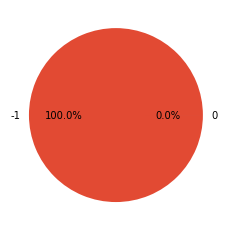

In [ ]:
plt.pie(df_bidask['l_t_lable'].value_counts().values,
        labels=[-1, 0], autopct='%1.1f%%')
plt.show()

In [ ]:
total_df = pd.concat([df, df_bidask], axis=1)
total_df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,close_change,close_lable,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39,p_b,p_a,p_t,m_+,l_t,l_t_lable
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,0.00,0,14024.25,2.0,14024.50,1.0,14024.75,1.0,14025.00,1.0,14025.25,2.0,14025.50,1.0,14025.75,1.0,14026.00,1.0,14026.25,2.0,14026.50,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0,14026.50,14066.5,14046.500,0.000,0.000000,0
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,0.25,0,14022.25,2.0,14022.50,2.0,14022.75,1.0,14023.00,1.0,14023.25,3.0,14023.50,2.0,14023.75,1.0,14024.00,1.0,14024.25,1.0,14024.50,2.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0,14024.50,14066.5,14045.500,-1.000,-1.000071,-1
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,0.00,0,14023.00,2.0,14023.25,1.0,14023.50,1.0,14023.75,2.0,14024.00,1.0,14024.25,1.0,14024.50,1.0,14024.75,1.0,14025.00,2.0,14025.25,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0,14025.25,14066.5,14045.875,0.375,-0.999973,-1


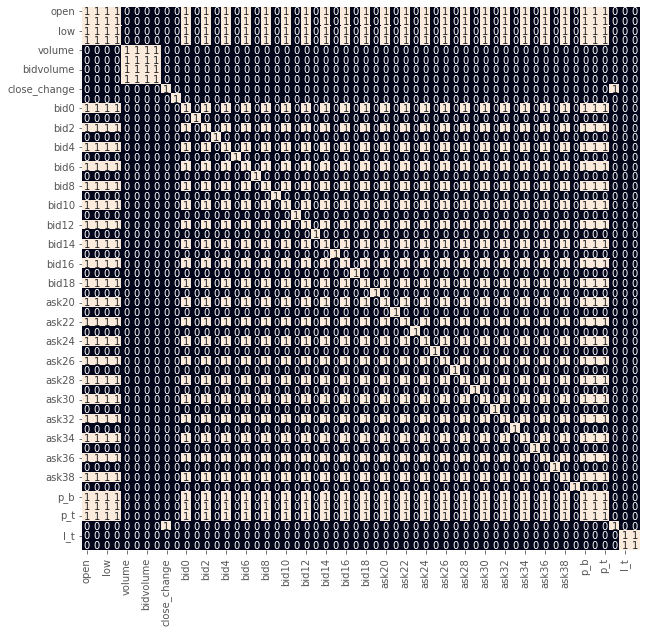

In [ ]:
plt.figure(figsize=(10, 10))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(total_df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [ ]:
gc.collect()

158394

# ML MODELING, BACKTESTING

## 1.CLASSIC ML use classification

In [ ]:
total_df.shape

(67121, 56)

In [ ]:
valid_horizon = 67121
67121 // 5

13424

In [ ]:
valid_horizon = 13424
train = total_df.head(-valid_horizon).copy()
test = total_df.tail(valid_horizon)

In [ ]:
total_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'numtrades', 'bidvolume',
       'askvolume', 'close_change', 'close_lable', 'bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39', 'p_b', 'p_a', 'p_t', 'm_+',
       'l_t', 'l_t_lable'],
      dtype='object')

In [ ]:
# x_train = train[['open', 'high', 'low',	"volume", "numtrades", "p_t", "bidvolume",	"askvolume", "bid18", "ask20"]]
y_train = train['close_lable']
x_train = train[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
# x_test = test[['open', 'high', 'low',	"volume", "numtrades", "p_t", "bidvolume",	"askvolume", "bid18", "ask20"]]
x_test = test[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
y_test = test['close_lable']
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [ ]:
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

x_train shape: (53697, 40), x_test shape: (13424, 40), y_train shape: (53697, 1), y_test shape: (13424, 1)


In [ ]:
scaler = StandardScaler()

In [ ]:
scaler = scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
models = [LogisticRegression(), XGBClassifier()]
# SVC(kernel='poly', probability=True)

for i in range(2):
  models[i].fit(x_train, y_train )
 
  print(f'{models[i]} : ')
  y_train_predict = models[i].predict(x_train)
  y_train_predict = y_train_predict.reshape(-1,1)
  y_test_predict = models[i].predict(x_test)
  y_test_predict = y_test_predict.reshape(-1,1)
  
  print('Training f1 Score : ', metrics.f1_score(y_train , y_train_predict, average=None))
  print('Test f1 Score : ', metrics.f1_score(y_test , y_test_predict, average=None))
  print()

LogisticRegression() : 
Training f1 Score :  [0.63438039 0.         0.58921991]
Test f1 Score :  [0.62870006 0.         0.28999168]

XGBClassifier(objective='multi:softprob') : 
Training f1 Score :  [0.62893646 0.01099164 0.55568746]
Test f1 Score :  [0.61006146 0.00107009 0.56440678]



## Backtest XGBClassifier

In [ ]:
backtest_data = total_df[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39', "close"]]
featuers = backtest_data[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
featuers = StandardScaler().fit_transform(featuers)
featuers = pd.DataFrame(featuers, columns = ['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39'])

In [ ]:
buy_signals = []
sell_signals =[]
trigger = 0
for x in range(len(backtest_data)):
  featuer = featuers.iloc[x].to_numpy()
  predict = models[0].predict(featuer.reshape(1, -1))
  if int(predict[0]) == 1 and trigger != 1:
    buy_signals.append(backtest_data["close"].iloc[x])
    sell_signals.append(float('nan'))
    trigger = 1
  elif predict[0] == -1 and trigger != -1:
    sell_signals.append(backtest_data["close"].iloc[x])
    buy_signals.append(float('nan'))
    trigger = -1
  else:
    buy_signals.append(float('nan'))
    sell_signals.append(float('nan'))


In [ ]:
backtest_data['Buy Signals'] = buy_signals
backtest_data['Sell Signals'] = sell_signals

In [ ]:
# plt.plot(backtest_data['close'], label='Share Price', color='lightgray', alpha=0.5)
# plt.scatter(backtest_data.index, backtest_data['Buy Signals'], label='Buy Signal', marker="^", color="#00ff00", lw=1)
# plt.scatter(backtest_data.index, backtest_data['Sell Signals'], label='Sell Signal', marker="v", color="#ff0000", lw=1)
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# Compute the percentage of variation of the asset
backtest_data["pct"] = backtest_data["close"].pct_change(1)
backtest_data.fillna(0, inplace=True)

In [ ]:
def filter_up(x):
    if x > 0:
      return 1
    else:
      return 0
def filter_down(x):
    if x > 0:
      return -1
    else:
      return 0

In [ ]:
backtest_data["signal_long"] = backtest_data["Buy Signals"].apply(filter_up)
backtest_data["signal_short"] = backtest_data["Sell Signals"].apply(filter_down)

In [ ]:
# Compute the positions
backtest_data["Position"] = (backtest_data["signal_short"].fillna(method="ffill")+ backtest_data["signal_long"].fillna(method="ffill"))

# Compute the return of the strategy
backtest_data["return"] = backtest_data["pct"]*(backtest_data["Position"].shift(1))

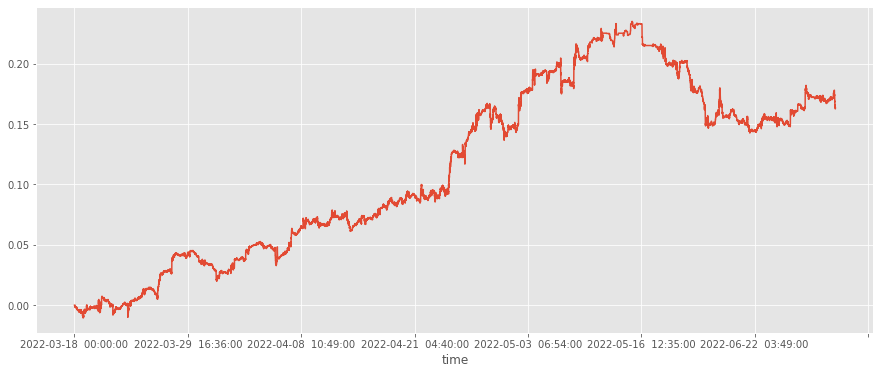

In [ ]:
backtest_data["return"].cumsum().plot(figsize=(15,6))

In [ ]:
def drawdown_function(serie):
# We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1
# We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)
# We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
# We compute drawdown
drawdown = drawdown_function(backtest_data["return"])
backtest_data["drawdown"] = drawdown 
# Computation Max drawdown
max_drawdown =  -np.min(drawdown)*100
print(f"Max drawdown: {np.round(max_drawdown,1)} %")

Max drawdown: 7.5 %


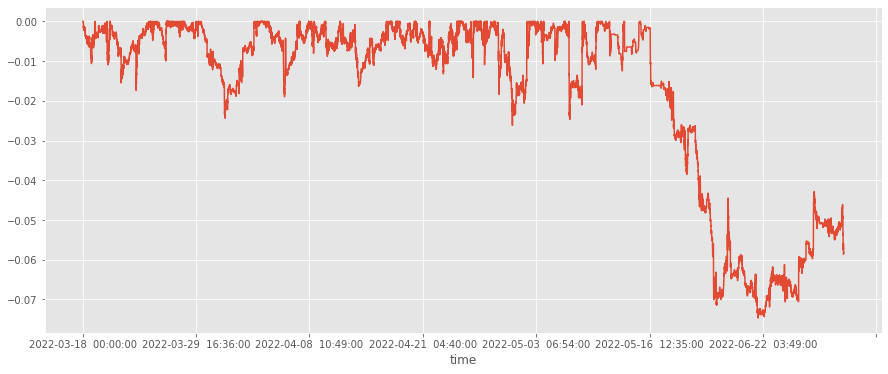

In [ ]:
plt.figure(figsize=(15,6))
backtest_data["drawdown"].plot()

plt.show()

## 2.DNN

## Backtest DNN Backtrader

In [ ]:
# !pip install backtrader
# import backtrader as bt
# import datetime

In [ ]:
# Create a Stratey
class LogisticRegression(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep references
        # ['open', 'high', 'low',	"volume", "numtrades", "p_t", "bidvolume",	"askvolume"]
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.datavolume = self.datas[0].volume
        # self.datanumtrades = self.datas[0].numtrades
        # self.datap_t = self.datas[0].p_t
        # self.databidvolume = self.datas[0].bidvolume
        # self.dataaskvolume = self.datas[0].askvolume
        # self.dataclose_lable = self.datas[0].close_lable
        self.dataclose = self.datas[0].close


    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        # x_train=[
        #     self.dataopen, self.datahigh, self.datalow,
        #     self.datavolume, self.datanumtrades, self.datap_t,
        #     self.databidvolume, self.dataaskvolume, self.dataclose_lable,
        # ]
        # x_train = scaler.transform(x_train)
        # predict = models[0].predict(x_train)
        # self.log('Predic, %.2f' % predict)
        # if predict == 1:
        #       self.log('BUY CREATE, %.2f' % self.dataclose[0])
        #       self.buy()
        # elif predict == -1:
        #       self.log('SELL CREATE, %.2f' % self.dataclose[0])
        #       self.sell()
        # else:
        #   self.log('Remain, %.2f' % self.dataclose[0])
        #   pass

NameError: ignored

In [ ]:
import backtrader.feeds as btfeed

datas = btfeed.GenericCSVData(
    dataname = "/content/DataWithBidAskData.csv" ,
    open = 1,
    high = 2,
    low	= 3,
    close	=4 ,
    volume= 5,
    numtrades = 6,
)

cerebro = bt.Cerebro()
cerebro.broker.setcash(1000.0)
feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(feed)
cerebro.addstrategy(LogisticRegression)

In [ ]:
# Add a FixedSize sizer according to the stake
# cerebro.addsizer(bt.sizers.FixedSize, stake=100)

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())